Arxiv has more than 1.5m articles in many fields of study. It was founded by Paul Ginsparg in 1991 and maintained and operated by Cornell University.

In this kernel I work with metadata information from this dataset: https://www.kaggle.com/Cornell-University/arxiv

It contains metadata of papers and information about citations.

Let's see what interesting insights can be extracted form this data!

*Work is still in progress*

![](https://storage.googleapis.com/kaggle-public-downloads/arXiv.JPG)

In [1]:
# import libraries

import numpy as np
import pandas as pd
import math

import gc
import os
import json
from collections import Counter, defaultdict
from tqdm.notebook import tqdm
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import plotly.graph_objs as go

%matplotlib inline
import plotly.express as px
import re
year_pattern = r'([1-2][0-9]{3})'

In [2]:
"""
Json files in the dataset are huge. Sadly, python has certain memory problems when loading huge json files.
As a result, I read this file using `yield` and get necessary information from in in the loop.
"""

def get_metadata():
    with open('arxiv_data/arxiv-metadata-oai-snapshot.json', 'r') as f:
        for line in f:
            yield line

In [3]:
# https://arxiv.org/help/api/user-manual
category_map = {
'astro-ph': 'Astrophysics',
'astro-ph.CO': 'Cosmology and Nongalactic Astrophysics',
'astro-ph.EP': 'Earth and Planetary Astrophysics',
'astro-ph.GA': 'Astrophysics of Galaxies',
'astro-ph.HE': 'High Energy Astrophysical Phenomena',
'astro-ph.IM': 'Instrumentation and Methods for Astrophysics',
'astro-ph.SR': 'Solar and Stellar Astrophysics',
'cond-mat.dis-nn': 'Disordered Systems and Neural Networks',
'cond-mat.mes-hall': 'Mesoscale and Nanoscale Physics',
'cond-mat.mtrl-sci': 'Materials Science',
'cond-mat.other': 'Other Condensed Matter',
'cond-mat.quant-gas': 'Quantum Gases',
'cond-mat.soft': 'Soft Condensed Matter',
'cond-mat.stat-mech': 'Statistical Mechanics',
'cond-mat.str-el': 'Strongly Correlated Electrons',
'cond-mat.supr-con': 'Superconductivity',
'cs.AI': 'Artificial Intelligence',
'cs.AR': 'Hardware Architecture',
'cs.CC': 'Computational Complexity',
'cs.CE': 'Computational Engineering, Finance, and Science',
'cs.CG': 'Computational Geometry',
'cs.CL': 'Computation and Language',
'cs.CR': 'Cryptography and Security',
'cs.CV': 'Computer Vision and Pattern Recognition',
'cs.CY': 'Computers and Society',
'cs.DB': 'Databases',
'cs.DC': 'Distributed, Parallel, and Cluster Computing',
'cs.DL': 'Digital Libraries',
'cs.DM': 'Discrete Mathematics',
'cs.DS': 'Data Structures and Algorithms',
'cs.ET': 'Emerging Technologies',
'cs.FL': 'Formal Languages and Automata Theory',
'cs.GL': 'General Literature',
'cs.GR': 'Graphics',
'cs.GT': 'Computer Science and Game Theory',
'cs.HC': 'Human-Computer Interaction',
'cs.IR': 'Information Retrieval',
'cs.IT': 'Information Theory',
'cs.LG': 'Machine Learning',
'cs.LO': 'Logic in Computer Science',
'cs.MA': 'Multiagent Systems',
'cs.MM': 'Multimedia',
'cs.MS': 'Mathematical Software',
'cs.NA': 'Numerical Analysis',
'cs.NE': 'Neural and Evolutionary Computing',
'cs.NI': 'Networking and Internet Architecture',
'cs.OH': 'Other Computer Science',
'cs.OS': 'Operating Systems',
'cs.PF': 'Performance',
'cs.PL': 'Programming Languages',
'cs.RO': 'Robotics',
'cs.SC': 'Symbolic Computation',
'cs.SD': 'Sound',
'cs.SE': 'Software Engineering',
'cs.SI': 'Social and Information Networks',
'cs.SY': 'Systems and Control',
'econ.EM': 'Econometrics',
'eess.AS': 'Audio and Speech Processing',
'eess.IV': 'Image and Video Processing',
'eess.SP': 'Signal Processing',
'gr-qc': 'General Relativity and Quantum Cosmology',
'hep-ex': 'High Energy Physics - Experiment',
'hep-lat': 'High Energy Physics - Lattice',
'hep-ph': 'High Energy Physics - Phenomenology',
'hep-th': 'High Energy Physics - Theory',
'math.AC': 'Commutative Algebra',
'math.AG': 'Algebraic Geometry',
'math.AP': 'Analysis of PDEs',
'math.AT': 'Algebraic Topology',
'math.CA': 'Classical Analysis and ODEs',
'math.CO': 'Combinatorics',
'math.CT': 'Category Theory',
'math.CV': 'Complex Variables',
'math.DG': 'Differential Geometry',
'math.DS': 'Dynamical Systems',
'math.FA': 'Functional Analysis',
'math.GM': 'General Mathematics',
'math.GN': 'General Topology',
'math.GR': 'Group Theory',
'math.GT': 'Geometric Topology',
'math.HO': 'History and Overview',
'math.IT': 'Information Theory',
'math.KT': 'K-Theory and Homology',
'math.LO': 'Logic',
'math.MG': 'Metric Geometry',
'math.MP': 'Mathematical Physics',
'math.NA': 'Numerical Analysis',
'math.NT': 'Number Theory',
'math.OA': 'Operator Algebras',
'math.OC': 'Optimization and Control',
'math.PR': 'Probability',
'math.QA': 'Quantum Algebra',
'math.RA': 'Rings and Algebras',
'math.RT': 'Representation Theory',
'math.SG': 'Symplectic Geometry',
'math.SP': 'Spectral Theory',
'math.ST': 'Statistics Theory',
'math-ph': 'Mathematical Physics',
'nlin.AO': 'Adaptation and Self-Organizing Systems',
'nlin.CD': 'Chaotic Dynamics',
'nlin.CG': 'Cellular Automata and Lattice Gases',
'nlin.PS': 'Pattern Formation and Solitons',
'nlin.SI': 'Exactly Solvable and Integrable Systems',
'nucl-ex': 'Nuclear Experiment',
'nucl-th': 'Nuclear Theory',
'physics.acc-ph': 'Accelerator Physics',
'physics.ao-ph': 'Atmospheric and Oceanic Physics',
'physics.app-ph': 'Applied Physics',
'physics.atm-clus': 'Atomic and Molecular Clusters',
'physics.atom-ph': 'Atomic Physics',
'physics.bio-ph': 'Biological Physics',
'physics.chem-ph': 'Chemical Physics',
'physics.class-ph': 'Classical Physics',
'physics.comp-ph': 'Computational Physics',
'physics.data-an': 'Data Analysis, Statistics and Probability',
'physics.ed-ph': 'Physics Education',
'physics.flu-dyn': 'Fluid Dynamics',
'physics.gen-ph': 'General Physics',
'physics.geo-ph': 'Geophysics',
'physics.hist-ph': 'History and Philosophy of Physics',
'physics.ins-det': 'Instrumentation and Detectors',
'physics.med-ph': 'Medical Physics',
'physics.optics': 'Optics',
'physics.plasm-ph': 'Plasma Physics',
'physics.pop-ph': 'Popular Physics',
'physics.soc-ph': 'Physics and Society',
'physics.space-ph': 'Space Physics',
'q-bio.BM': 'Biomolecules',
'q-bio.CB': 'Cell Behavior',
'q-bio.GN': 'Genomics',
'q-bio.MN': 'Molecular Networks',
'q-bio.NC': 'Neurons and Cognition',
'q-bio.OT': 'Other Quantitative Biology',
'q-bio.PE': 'Populations and Evolution',
'q-bio.QM': 'Quantitative Methods',
'q-bio.SC': 'Subcellular Processes',
'q-bio.TO': 'Tissues and Organs',
'q-fin.CP': 'Computational Finance',
'q-fin.EC': 'Economics',
'q-fin.GN': 'General Finance',
'q-fin.MF': 'Mathematical Finance',
'q-fin.PM': 'Portfolio Management',
'q-fin.PR': 'Pricing of Securities',
'q-fin.RM': 'Risk Management',
'q-fin.ST': 'Statistical Finance',
'q-fin.TR': 'Trading and Market Microstructure',
'quant-ph': 'Quantum Physics',
'stat.AP': 'Applications',
'stat.CO': 'Computation',
'stat.ME': 'Methodology',
'stat.ML': 'Machine Learning',
'stat.OT': 'Other Statistics',
'stat.TH': 'Statistics Theory'}

In [4]:
major_categories = list(category_map.keys())
def check_in_major_categories(cat):
    if cat in major_categories:
        return cat
    else:
        return None

## Analyze Arxiv

FIRST
Simplify all the code. Make it so that I only have to read things in once, and then I can analyze however I want over time. 
Don't use the L2 norm but instead the L1 norm so that I can directly sum things. 

To do
1. Combine categories, into larger groups, to see evolution between major fields.
2. Also have option to only look within a certain field. 
2. Simplify all the code. 

Maybe get it to work with individual movements rather than averages at a given time? 
I want to know what people move between, not just the average movements are in or out. 

### Basic utils

In [5]:
# Basic utils for dates and stuff

def extract_decimal_year_of_pub(paper_versions):
    v1_date_str = next((v['created'] for v in paper_versions if v['version'] == 'v1'), None)

    if v1_date_str is None:
        return None

    v1_date = datetime.strptime(v1_date_str, '%a, %d %b %Y %H:%M:%S %Z')
    year_start = datetime(v1_date.year, 1, 1)
    year_end = datetime(v1_date.year + 1, 1, 1)

    days_since_year_start = (v1_date - year_start).days
    days_in_year = (year_end - year_start).days

    decimal_year = v1_date.year + days_since_year_start / days_in_year

    return decimal_year

def bin_date(date_in_years, bin_size):
    DATE_ROUND_ERR = 3
    return round(math.floor(date_in_years / bin_size) * bin_size + bin_size/2.0, DATE_ROUND_ERR)

### Extract data by publication

In [42]:
# Create a pandas dataframe with each publication information 

MAX_EXTRACTION_LENGTH = 5000000  # How many publications to load to save time 
MAX_PUBLICATIONS = 50 # max publications allowed to consider an author (otherwise it's likely a non-unique name)
MIN_PUBLICATIONS = 2

# Create an empty list to accumulate rows
rows = []

length = 0
metadata = get_metadata()
for paper in metadata:
    if length > MAX_EXTRACTION_LENGTH:
        break
    paper_data = json.loads(paper)
    
    # Extract and process the data
    categories = list(set([check_in_major_categories(cat) for cat in paper_data['categories'].split() 
                  if check_in_major_categories(cat) is not None])) # removes duplicates
    if len(categories) == 0:
        continue  # skip this one, it's a weird paper with no normal tags 
    paper_id = paper_data['id']
    pub_date = extract_decimal_year_of_pub(paper_data['versions'])
    authors_parsed = paper_data['authors_parsed']
    
    # Create a dictionary with the extracted data
    row = {'id': paper_id, 'categories': categories, 'pub_date': pub_date, 'authors_parsed': authors_parsed}

    # Append the row to the rows list
    rows.append(row)
    
    if length % 100_000 == 0:
        print(length, 'done')
    length += 1

# Create a DataFrame using the accumulated rows
columns = ['id', 'categories', 'pub_date', 'authors_parsed']
df = pd.DataFrame(rows, columns=columns)

print(len(df))

0 done
100000 done
200000 done
300000 done
400000 done
500000 done
600000 done
700000 done
800000 done
900000 done
1000000 done
1100000 done
1200000 done
1300000 done
1400000 done
1500000 done
1600000 done
1700000 done
1800000 done
1900000 done
2000000 done
2100000 done
2200000 done
2208915


### Get unique categories and mapping

In [43]:

# Get a list of all unique categories
unique_categories = sorted(set(cat for categories in df['categories'] for cat in categories))

def index_to_category(ind):
    return unique_categories[ind]

def category_to_index(cat):
    return unique_categories.index(cat)

print(unique_categories)

['astro-ph', 'astro-ph.CO', 'astro-ph.EP', 'astro-ph.GA', 'astro-ph.HE', 'astro-ph.IM', 'astro-ph.SR', 'cond-mat.dis-nn', 'cond-mat.mes-hall', 'cond-mat.mtrl-sci', 'cond-mat.other', 'cond-mat.quant-gas', 'cond-mat.soft', 'cond-mat.stat-mech', 'cond-mat.str-el', 'cond-mat.supr-con', 'cs.AI', 'cs.AR', 'cs.CC', 'cs.CE', 'cs.CG', 'cs.CL', 'cs.CR', 'cs.CV', 'cs.CY', 'cs.DB', 'cs.DC', 'cs.DL', 'cs.DM', 'cs.DS', 'cs.ET', 'cs.FL', 'cs.GL', 'cs.GR', 'cs.GT', 'cs.HC', 'cs.IR', 'cs.IT', 'cs.LG', 'cs.LO', 'cs.MA', 'cs.MM', 'cs.MS', 'cs.NA', 'cs.NE', 'cs.NI', 'cs.OH', 'cs.OS', 'cs.PF', 'cs.PL', 'cs.RO', 'cs.SC', 'cs.SD', 'cs.SE', 'cs.SI', 'cs.SY', 'econ.EM', 'eess.AS', 'eess.IV', 'eess.SP', 'gr-qc', 'hep-ex', 'hep-lat', 'hep-ph', 'hep-th', 'math-ph', 'math.AC', 'math.AG', 'math.AP', 'math.AT', 'math.CA', 'math.CO', 'math.CT', 'math.CV', 'math.DG', 'math.DS', 'math.FA', 'math.GM', 'math.GN', 'math.GR', 'math.GT', 'math.HO', 'math.IT', 'math.KT', 'math.LO', 'math.MG', 'math.MP', 'math.NA', 'math.NT',

### Extract data by author

In [44]:
# Create a dictionary with the contributions of each unique author name. 

# Initialize an empty dictionary to store the authors and their papers
author_papers = {}

# Iterate through the rows of the DataFrame
for index, row in df.iterrows():
    
    paper_id = row['id']
    categories = row['categories']
    pub_date = row['pub_date']
    authors_parsed = row['authors_parsed']

    # Iterate through the authors of each paper
    for author in authors_parsed:
        author_key = "".join(author)  # Create a unique author key

        # If the author is not in the dictionary, add them with their first paper
        if author_key not in author_papers:
            author_papers[author_key] = []

        # Add the paper information to the author's list of papers
        author_papers[author_key].append([paper_id, pub_date, categories])

print(len(author_papers))


1762689


### Extract author status data by date 

In [58]:
"""
# Initialize the author_status_metadata 
# Contains a list of categories currently being published by each author during each timebin
# as well as the previous author's time bin
    
"""

YEARS_BINSIZE = 1.0  # how large bins to group together on derivative calculation

author_status_metadata = defaultdict(list)

for author_key, papers in author_papers.items():
    if not (MIN_PUBLICATIONS <= len(papers) <= MAX_PUBLICATIONS):
        continue  # only use authors with a few publications, or not too many (otherwise likely a non-unique name)

    bin_size = YEARS_BINSIZE
    binned_papers = defaultdict(set)

    # Bin the papers by date
    for p in papers:
        _, date, categories_as_words = p
        binned_date = bin_date(date, bin_size)
        categories_as_indices = set([category_to_index(item) for item in categories_as_words])
        binned_papers[binned_date].update(categories_as_indices)

    # Find the min and max binned dates
    min_binned_date = bin_date(min(date for date in binned_papers.keys()), bin_size)
    max_binned_date = bin_date(max(date for date in binned_papers.keys()), bin_size)

    # Iterate over the binned dates in the known range
    current_date = min_binned_date
    prev_year_categories = set(binned_papers[min_binned_date])
    while current_date <= max_binned_date + 0.5 * bin_size:  # add 0.5 to not miss last bin
        if binned_papers[current_date]:
            current_year_categories = set(binned_papers[current_date])
        else:
            current_year_categories = prev_year_categories

        author_status_metadata[current_date].append([list(current_year_categories), list(prev_year_categories)])
        
        prev_year_categories = current_year_categories
        current_date = bin_date(current_date + 1.01*bin_size, bin_size)  # add 1.01 to make sure to reach next bin

sorted_dates = list(sorted(author_status_metadata.keys()))
print(len(sorted_dates))

38


In [59]:
# Now for each bin, we can take the list of papers, and measure things. 

def count_authors_by_category(author_status_data, unique_categories):
    category_count = np.zeros(len(unique_categories))

    for author in author_status_data:
        current_categories = author[0]
        weight = 1 / len(current_categories)
        for category in current_categories:
            category_count[category] += weight

    return category_count

def count_transitions(author_status_data, unique_categories):    
    transition_count = np.zeros((len(unique_categories), len(unique_categories)))
    
    for author in author_status_data:
        current_categories = author[0]
        previous_categories = author[1]

        transition_vector = np.zeros(len(unique_categories))

        for cat in current_categories:
            transition_vector[cat] += 1 / len(current_categories)        
        for cat in previous_categories:
            transition_vector[cat] -= 1 / len(previous_categories)

        neg_source_mask = transition_vector[previous_categories] < 0
        pos_target_mask = transition_vector[current_categories] > 0

        for source_index, source_neg in zip(previous_categories, neg_source_mask):
            if not source_neg:
                continue

            ratio = (-transition_vector[source_index]) / np.sum(-transition_vector[transition_vector < 0])
            for target_index, target_pos in zip(current_categories, pos_target_mask):
                if target_pos:
                    transition_count[source_index, target_index] += ratio * transition_vector[target_index]

    return transition_count


author_counts = {date: count_authors_by_category(author_status_metadata[date], unique_categories) for date in sorted_dates}
author_transitions = {date: count_transitions(author_status_metadata[date], unique_categories) for date in sorted_dates}
print('done')

done


### Functions to collapse categories

In [567]:
def collapse_categories_function(cat):
    """
    This is the major categories collapse.
    
    Returns AI fields if category is in there
    Otherwise returns some major category 
    """
    
    # Basic dictionary to condense categories down to prefixes. 
    AI_fields = {
    'cs.AI',
    'cs.NA',
    'cs.LG',
    'cs.CV',
    'cs.SY',
    'cs.CL',
    'cs.RO',
    'stat.ML',
    'eess.AS',
    'eess.IV',
    'eess.SP'
    }

    # dictionary to condense prefixes further 
    prefix_condensation_dict = defaultdict(lambda: 'other')
    prefix_condensation_dict.update({
    'astro-ph' : 'astrophysics',
    'cond-mat' : 'condensed matter physics',
    'cs' : 'computer science (non AI)',
    'econ' : 'econometrics',
    'gr' : 'physics',
    'hep' : 'high energy physics',
    'math' : 'math',
    'nlin' : 'nonlinear systems',
    'nucl' : 'nuclear physics',
    'physics' : 'physics',
    'q-bio' : 'physics',
    'q-fin' : 'finance',
    'quant-ph' : 'physics',
    'stat' : 'statistics (non AI)'
    })

    if cat in AI_fields:
        return 'AI fields'
    else:
        for pattern in prefix_condensation_dict.keys():
            if cat.lower().startswith(pattern.lower()):
                return prefix_condensation_dict[pattern]
    return 'other'


# def collapse_categories_function(cat):
#     """
#     This one loads a specific prefix but keeps all subfields, and puts the rest in 'other'
    
#     Useful for seeing relative strength of subfields
#     """
    
#     explore_specific_field_prefix = 'cs'
    
#     if cat.lower().startswith(explore_specific_field_prefix.lower()):
#         return cat
#     else:
#         return 'other'
    
# def collapse_categories_function(cat):
#     """
#     This one keeps all categories
#     """
#     return cat


collapse_categories_function('nucl-ex')

'nuclear physics'

In [568]:
def create_collapse_index_mapping(collapse_dict):
    unique_categories = list(sorted(set(collapse_dict.keys())))
    collapsed_unique_categories = list(sorted(set(collapse_dict.values())))
    index_mapping = {}

    for ind, cat in enumerate(unique_categories):
        collapsed_cat = collapse_dict[cat]
        collapsed_ind = collapsed_unique_categories.index(collapsed_cat)
        index_mapping[ind] = collapsed_ind

    return index_mapping, collapsed_unique_categories

def collapse_transition_matrix(transition_count, index_mapping):
    """
    Careful here. Don't count transitions that are within a collapsed class. 
    """
    
    n_collapsed = len(set(index_mapping.values()))
    collapsed_transition_count = np.zeros((n_collapsed, n_collapsed))

    for source_ind, collapsed_source_ind in index_mapping.items():
        for target_ind, collapsed_target_ind in index_mapping.items():
            
            # Only add to matrix if we are transitioning in or out of classes. 
            if collapsed_target_ind != collapsed_source_ind: 
                collapsed_transition_count[collapsed_source_ind, collapsed_target_ind] += transition_count[source_ind, target_ind]

    return collapsed_transition_count

def collapse_vector(vector, index_mapping):
    
    n_collapsed = len(set(index_mapping.values()))
    collapsed_vector = np.zeros(n_collapsed)

    for source_ind, collapsed_source_ind in index_mapping.items():
        collapsed_vector[collapsed_source_ind] += vector[source_ind]

    return collapsed_vector

In [569]:

collapse_dict = {cat : collapse_categories_function(cat) for cat in unique_categories}
collapse_index_mapping, unique_categories_collapsed = create_collapse_index_mapping(collapse_dict)

author_counts_collapsed = {date: collapse_vector(author_counts[date], collapse_index_mapping) 
                               for date in sorted_dates}

author_transitions_collapsed = {date: collapse_transition_matrix(author_transitions[date], collapse_index_mapping) 
                               for date in sorted_dates}

print(author_transitions_collapsed[sorted_dates[-1]].shape)

(12, 12)


## Display results

In [641]:
# There is a lag for years to plot, since I am only showing currently active people
CUTOFF_YEAR_PLOT = 2024
# This is because I only count authors during a year if they are active in a future year
# if we include up to present day, I will omit a lot of authors who are in reality still active.
# So a few year delay is necessary so that, when discussing an author in 2020, 
# I have a good idea if they are still active in 2020 based on whether they publish in 2021, 2022 2023...

In [642]:
def plot_counts(counts_data, category_names):
    fig = go.Figure()

    # Plot the data and add labels to the lines
    for which_cat, category_name in enumerate(category_names):
        plt_vals = [counts_data[date][which_cat] 
                    for date in sorted_dates if date < CUTOFF_YEAR_PLOT]
        #fig.add_trace(go.Scatter(x=date, y=deriv_x, mode='lines+markers', marker=dict(size=3), name=category_name))
        fig.add_trace(go.Scatter(
            x=sorted_dates,
            y=plt_vals,
            mode='lines+markers',
            marker=dict(size=3),
            name=category_name,
            hovertemplate='%{y:.2f}',
            # line=dict(color='gray', width=1),
            hoverinfo='name+y',
        ))

    # Customize the layout
    fig.update_layout(
        title="Author counts",
        xaxis_title="Years",
        yaxis_title="Total per " + str(YEARS_BINSIZE) + " years",
        hovermode="closest",
        width=800,
        height=600,
        # yaxis_range=[-plt_range, plt_range]
    )

    fig.show()

In [643]:
def plot_transitions(transition_data, category_names, source_index):
    fig = go.Figure()

    # Plot the data and add labels to the lines
    for which_cat, category_name in enumerate(category_names):
        plt_vals = [transition_data[date][source_index][which_cat] 
                    for date in sorted_dates if date < CUTOFF_YEAR_PLOT]
        #fig.add_trace(go.Scatter(x=date, y=deriv_x, mode='lines+markers', marker=dict(size=3), name=category_name))
        fig.add_trace(go.Scatter(
            x=sorted_dates,
            y=plt_vals,
            mode='lines+markers',
            marker=dict(size=3),
            name=category_name,
            hovertemplate='%{y:.2f}',
            # line=dict(color='gray', width=1),
            hoverinfo='name+y',
        ))

    # Customize the layout
    fig.update_layout(
        title="Author transition counts from " + category_names[source_index],
        xaxis_title="Years",
        yaxis_title="Total per " + str(YEARS_BINSIZE) + " years",
        hovermode="closest",
        width=800,
        height=600,
        # yaxis_range=[-plt_range, plt_range]
    )

    fig.show()

In [644]:
def plot_relative_transitions(transition_data, counts_data, category_names, source_index):
    fig = go.Figure()
    

    def clip_trans_rate(trans, counts):
        
        min_count_to_report = 20
        
        if counts < min_count_to_report:
            return 0
        else:
            return trans/(max(np.abs(trans),np.abs(counts)))
                    
    
    # Plot the data and add labels to the lines
    for which_cat, category_name in enumerate(category_names):
        
        plt_vals = [clip_trans_rate(transition_data[date][source_index][which_cat],counts_data[date][source_index])
                    for date in sorted_dates if date < CUTOFF_YEAR_PLOT]
        #fig.add_trace(go.Scatter(x=date, y=deriv_x, mode='lines+markers', marker=dict(size=3), name=category_name))
        fig.add_trace(go.Scatter(
            x=sorted_dates,
            y=plt_vals,
            mode='lines+markers',
            marker=dict(size=3),
            name=category_name,
            hovertemplate='%{y:.2f}',
            # line=dict(color='gray', width=1),
            hoverinfo='name+y',
        ))

    # Customize the layout
    fig.update_layout(
        title="Approximate transition rate from " + category_names[source_index] ,
        xaxis_title="Years",
        yaxis_title="Transition rate per " + str(YEARS_BINSIZE) + " years",
        hovermode="closest",
        width=800,
        height=600,
        # yaxis_range=[-plt_range, plt_range]
    )

    fig.show()

In [645]:
def plot_total_rate_of_leaving(transition_data, counts_data, category_names):
    fig = go.Figure()
    

    def clip_trans_rate(trans, counts):
        
        min_count_to_report = 20
        
        if counts < min_count_to_report:
            return 0
        else:
            return trans/(max(np.abs(trans),np.abs(counts)))
                    
    
    # Plot the data and add labels to the lines
    for source_index, category_name in enumerate(category_names):
        
        plt_vals = [clip_trans_rate(np.sum(transition_data[date][source_index]),counts_data[date][source_index])
                    for date in sorted_dates if date < CUTOFF_YEAR_PLOT]
        #fig.add_trace(go.Scatter(x=date, y=deriv_x, mode='lines+markers', marker=dict(size=3), name=category_name))
        fig.add_trace(go.Scatter(
            x=sorted_dates,
            y=plt_vals,
            mode='lines+markers',
            marker=dict(size=3),
            name=category_name,
            hovertemplate='%{y:.2f}',
            # line=dict(color='gray', width=1),
            hoverinfo='name+y',
        ))

    # Customize the layout
    fig.update_layout(
        title="Approximate transition rate out of a field",
        xaxis_title="Years",
        yaxis_title="Transition rate per " + str(YEARS_BINSIZE) + " years",
        hovermode="closest",
        width=800,
        height=600,
        # yaxis_range=[-plt_range, plt_range]
    )

    fig.show()

In [646]:
def plot_total_rate_of_entering(transition_data, counts_data, category_names):
    fig = go.Figure()
    

    def clip_trans_rate(trans, counts):
        
        min_count_to_report = 20
        
        if counts < min_count_to_report:
            return 0
        else:
            return trans/(max(np.abs(trans),np.abs(counts)))
                    
    
    # Plot the data and add labels to the lines
    for target_index, category_name in enumerate(category_names):
        
        plt_vals = [clip_trans_rate(np.sum(np.array(transition_data[date])[:,target_index]),counts_data[date][target_index])
                    for date in sorted_dates if date < CUTOFF_YEAR_PLOT]
        #fig.add_trace(go.Scatter(x=date, y=deriv_x, mode='lines+markers', marker=dict(size=3), name=category_name))
        fig.add_trace(go.Scatter(
            x=sorted_dates,
            y=plt_vals,
            mode='lines+markers',
            marker=dict(size=3),
            name=category_name,
            hovertemplate='%{y:.2f}',
            # line=dict(color='gray', width=1),
            hoverinfo='name+y',
        ))

    # Customize the layout
    fig.update_layout(
        title="Approximate rate out of people switching into a field, per total in field",
        xaxis_title="Years",
        yaxis_title="Transition rate per " + str(YEARS_BINSIZE) + " years",
        hovermode="closest",
        width=800,
        height=600,
        # yaxis_range=[-plt_range, plt_range]
    )

    fig.show()

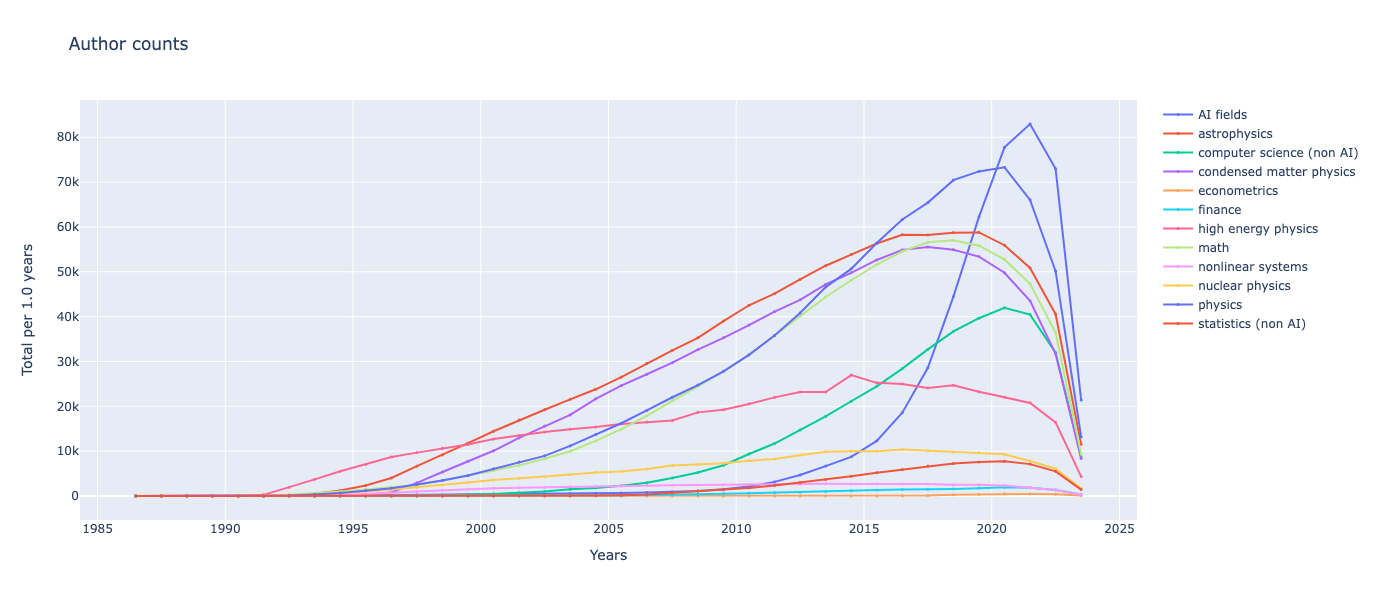

In [647]:
plot_counts(author_counts_collapsed, unique_categories_collapsed)

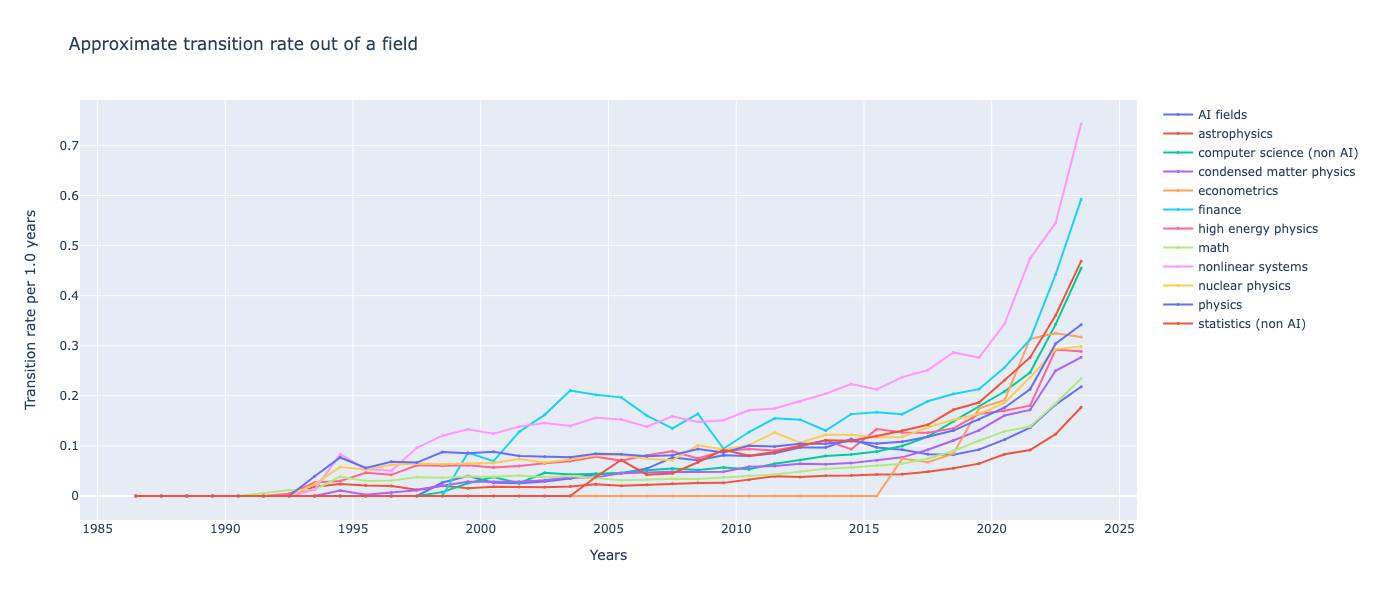

In [648]:
plot_total_rate_of_leaving(author_transitions_collapsed, author_counts_collapsed, 
                          unique_categories_collapsed)

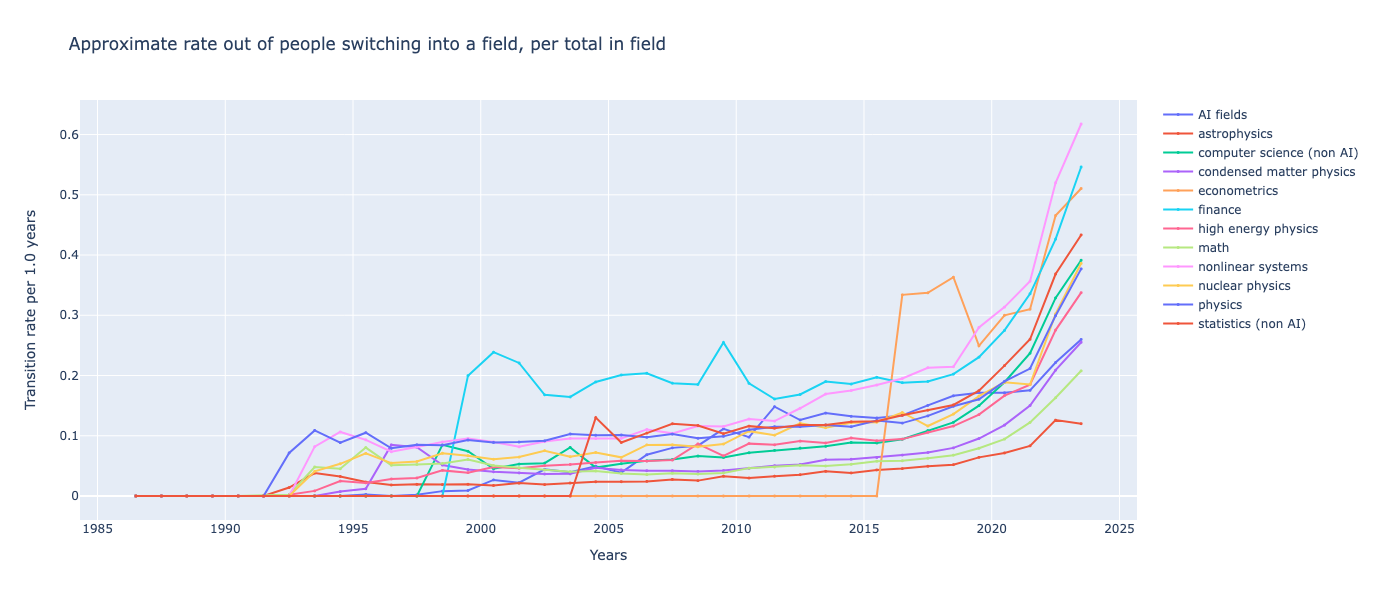

In [649]:
plot_total_rate_of_entering(author_transitions_collapsed, author_counts_collapsed, 
                          unique_categories_collapsed)

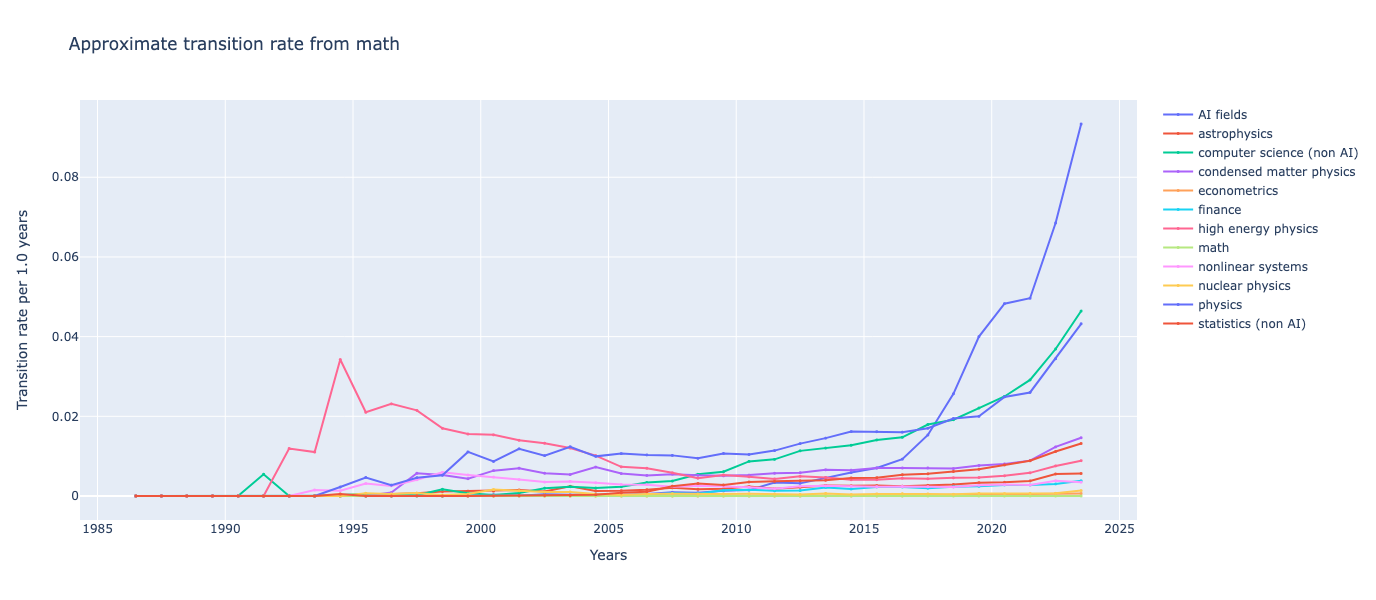

In [650]:
cat = 'math'
# plot_transitions(author_transitions_collapsed, unique_categories_collapsed, unique_categories_collapsed.index(cat))
plot_relative_transitions(author_transitions_collapsed, author_counts_collapsed, 
                          unique_categories_collapsed, unique_categories_collapsed.index(cat))

In [651]:
# for cat in unique_categories[0:5]:
#     plot_relative_transitions(author_transitions, author_counts, 
#                           unique_categories, unique_categories.index(cat))